In [11]:
import sys
#sys.path.insert(0, "../input/timm-efficientdet-pytorch")
#sys.path.insert(0, "../input/omegaconf")

import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold, KFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import torch.nn as nn
from glob import glob

SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [12]:
"""
marking = pd.read_csv('../input/global-wheat-detection/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)
"""
#marking = pd.DataFrame({"image_id":[os.path.splitext(i)[0] for i in os.listdir("/home/ubuntu/datasets/signate/fish/train_images")]})
annos = os.listdir("/home/ubuntu/datasets/signate/fish/train_annotations")
anno_path = "/home/ubuntu/datasets/signate/fish/train_annotations/"
import json
img_id = []
w = []

for anno in annos:
    #print(anno[:-5])
    n = 0
    with open(anno_path + anno) as f:
        l = json.load(f)["labels"]
        l_keys = l.keys()
        for k in l_keys:
            if k in ["Jumper School","Breezer School"]:

                n += len(l[k])
    #print(n)
    if not n == 0:
        img_id.append(anno[:-5])
            #for box in l[k]:
                #print(box)
    
marking = pd.DataFrame({"image_id":img_id})


#skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf = KFold(n_splits=5, shuffle=True, random_state=14)


df_folds = marking[['image_id']].copy()
#df_folds.loc[:, 'bbox_count'] = 1
#df_folds = df_folds.groupby('image_id').count()
#df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
#df_folds.loc[:, 'stratify_group'] = np.char.add(
#    df_folds['source'].values.astype(str),
#    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
#)
df_folds.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index)):
#for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

In [13]:
annos = os.listdir("/home/ubuntu/datasets/signate/fish/train_annotations")
anno_path = "/home/ubuntu/datasets/signate/fish/train_annotations/"
import json
img_id = []
w = []

for anno in annos:
    #print(anno[:-4])
    n = 0
    with open(anno_path + anno) as f:
        l = json.load(f)["labels"]
        l_keys = l.keys()
        for k in l_keys:
            if k in ["Jumper School","Breezer School"]:

                n += len(l[k])
    #print(n)
    if not n == 0:
        img_id.append(anno[:-4])
            #for box in l[k]:
                #print(box)
    
marking = pd.DataFrame({"image_id":img_id})


In [14]:
def get_train_transforms():
    return A.Compose(
        [
#            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=2, max_h_size=32, max_w_size=32, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [15]:
TRAIN_ROOT_PATH = '../input/global-wheat-detection/train'
TRAIN_ROOT_PATH = "/home/ubuntu/datasets/signate/fish/train_images"
ANNO_ROOT_PATH = "/home/ubuntu/datasets/signate/fish/train_annotations/"


class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.test or random.random() > 0.0:
            image, boxes, labels = self.load_image_and_boxes(index)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)

        # there is only one class
        #labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = torch.tensor(labels)
        target['image_id'] = torch.tensor([index])
        
        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id
    
    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = []
        labels = []
        label_id = ["Jumper School","Breezer School"]
        with open(ANNO_ROOT_PATH + image_id + ".json") as f:
            l = json.load(f)["labels"]
            l_keys = l.keys()
            for k in l_keys:
                if k in label_id:
                    for box in l[k]:
                        boxes.append(box)
                        labels.append(label_id.index(k) + 1)

        return image, np.array(boxes), labels
    
    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []
        
        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

In [16]:
fold_number = 0

train_dataset = DatasetRetriever(
    #image_ids=df_folds[df_folds['fold'] != fold_number].index.values,
    image_ids=df_folds[df_folds['fold'] != fold_number].image_id.values,
    marking=marking,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] == fold_number].image_id.values,
    marking=marking,
    transforms=get_valid_transforms(),
    test=True,
)

tensor([[188.2074, 265.0667, 310.2815, 345.3333],
        [292.9778, 337.3333, 369.5407, 388.6667],
        [280.6519, 438.6667, 345.8370, 510.4000]], dtype=torch.float64)


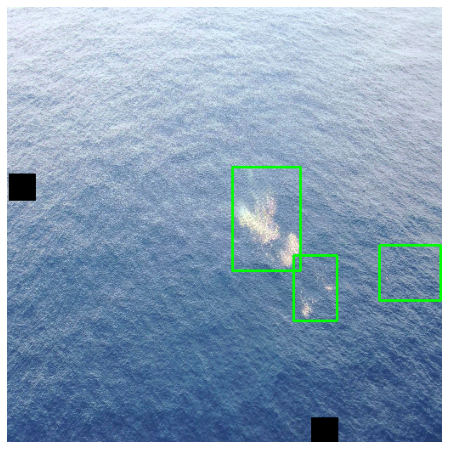

In [87]:
image, target, image_id = train_dataset[0]
print(target["boxes"])

boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image)

In [18]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [29]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                #loss= self.model(images, {"bbox":boxes, "cls":labels})["loss"]
                target_res = {}
                target_res['bbox'] = boxes
                target_res['cls'] = labels 
                target_res["img_scale"] = torch.tensor([1.0] * batch_size, dtype=torch.float).to(self.device)
                target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to(self.device)

                outputs = self.model(images, target_res)
                loss = outputs["loss"]
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )


            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]
            
            self.optimizer.zero_grad()

            output = self.model(images, {"bbox":boxes, "cls":labels})
            loss = output["loss"]
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')


In [30]:
class TrainGlobalConfig:
    num_workers = 2
    batch_size = 1
    n_epochs = 40 # n_epochs = 40
    lr = 0.0002

    folder = 'effdet5-cutmix-augmix'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

In [31]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.load("effdet5-cutmix-augmix/last-checkpoint.bin")
    fitter.fit(train_loader, val_loader)

In [32]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_net():
    config = get_efficientdet_config('tf_efficientdet_d5')
    config.num_classes = 2
    config.image_size = (512,512)
    #print(config)

    net = EfficientDet(config, pretrained_backbone=False)
    #checkpoint = torch.load("effdet5-cutmix-augmix/best-checkpoint-002epoch.bin")
    #net.load_state_dict(checkpoint['model_state_dict'])

    #checkpoint = torch.load('../input/efficientdet/efficientdet_d5-ef44aea8.pth')
    #net.load_state_dict(checkpoint)

    net.reset_head(num_classes=2)

    net.class_net = HeadNet(config, num_outputs=2)
    #net.class_net = HeadNet(config, num_outputs=2, norm_kwargs=dict(eps=.001, momentum=.01))

    return DetBenchTrain(net, config)

net = get_net()
#net = nn.DataParallel(net)

In [33]:
run_training()

Fitter prepared. Device is cuda:0

2021-01-16T04:32:17.429439
LR: 5e-05
[RESULT]: Train. Epoch: 20, summary_loss: 0.00000, time: 0.75998
0.07080553472042084mary_loss: 0.00000, time: 0.21489
0.8136565685272217mmary_loss: 1.69380, time: 0.28497
0.4372499883174896mmary_loss: 1.44556, time: 0.35866
0.179607555270195ummary_loss: 1.30067, time: 0.44279
0.16996221244335175mary_loss: 1.26152, time: 0.50552
0.22409749031066895mary_loss: 1.45072, time: 0.59160
0.42457953095436096mary_loss: 1.33065, time: 0.69826
0.09361676871776581mary_loss: 1.24154, time: 0.79451
0.4227568209171295mmary_loss: 1.34691, time: 0.89703
0.21441897749900818mary_loss: 1.26096, time: 0.99237
0.15364901721477509mmary_loss: 1.25965, time: 1.07555
0.32070037722587585mmary_loss: 1.30467, time: 1.14825
0.34925219416618347mmary_loss: 1.27886, time: 1.20806
0.39564254879951477mmary_loss: 1.22289, time: 1.29656
0.2572379410266876ummary_loss: 1.23144, time: 1.38504
0.29873010516166687mmary_loss: 1.28111, time: 1.48508
0.8301653

0.377806156873703 summary_loss: 1.29938, time: 13.29406
0.7366769313812256summary_loss: 1.29341, time: 13.39475
0.4245188236236572summary_loss: 1.28968, time: 13.48702
0.5963048338890076summary_loss: 1.29297, time: 13.56142
0.08826244622468948ummary_loss: 1.29122, time: 13.62204
0.23250538110733032ummary_loss: 1.29969, time: 13.70481
0.03981734812259674ummary_loss: 1.30352, time: 13.79343
0.412757933139801 summary_loss: 1.31886, time: 13.89399
0.49744346737861633ummary_loss: 1.32265, time: 13.99519
0.7704435586929321summary_loss: 1.31750, time: 14.08824
0.053657617419958115mmary_loss: 1.31823, time: 14.19288
0.5049945712089539summary_loss: 1.31955, time: 14.28770
0.6449880599975586summary_loss: 1.31784, time: 14.37710
0.7977852821350098summary_loss: 1.31313, time: 14.47164
0.7698910236358643summary_loss: 1.31117, time: 14.55166
0.3003444969654083summary_loss: 1.30450, time: 14.61494
0.1083265095949173summary_loss: 1.30572, time: 14.70097
0.12304560840129852ummary_loss: 1.30913, time: 1

KeyboardInterrupt: 

In [34]:
class submitDataset(Dataset):
    def __init__(self, src = "/home/ubuntu/datasets/signate/fish/test_images/", transform = False):
        super().__init__()
        self.src_path = src
        self.transforms = transform
        self.image_ids = os.listdir(self.src_path)

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]  
        image= self.load_image(image_id)
        sample = {
            "img_scale":torch.tensor(1.0).float(),
            "img_size":torch.tensor([512,512])}
        if self.transforms:
            image = self.transforms(**{'image': image})
        return image["image"], sample, image_id

        #return torch.tensor(image["image"], dtype = torch.float), sample, image_id
    
    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image(self, image_id):
        image = cv2.imread(f'{self.src_path}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        return image
    
def get_test_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0, 
        )

sub_dataset = submitDataset(transform = get_test_transforms())

In [19]:
image,sample = sub_dataset[2]
#print(sample)
#boxes = target['boxes'].cpu().numpy().astype(np.int32)
boxes = out[2][0][:, :4]
boxes = boxes[:10]

numpy_image = image.permute(1,2,0).cpu().numpy()
numpy_image = cv2.resize(numpy_image, (512, 512))
fig, ax = plt.subplots(1, 1, figsize=(10, 16))

for box in boxes:
    box = box.cpu().detach().numpy()
    #print(box)
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image)

NameError: name 'sub_dataset' is not defined

In [78]:

def test_output(test_loader, weight = "effdet5-cutmix-augmix/best-checkpoint-014epoch.bin"):
    checkpoint = torch.load(weight)
    net.model.load_state_dict(checkpoint['model_state_dict'])
    net.to('cuda:2')
    net.eval()
    summary_loss = AverageMeter()
    t = time.time()
    output_detections = []
    ids = []
    device = "cuda:2"
    for step, (images, targets, image_ids) in enumerate(test_loader):
        print("\r", image_ids, end = "")
        with torch.no_grad():
            #images = torch.stack(images)
            images = images.unsqueeze(0)
            batch_size = images.shape[0]
            images = images.to(device).float().to(device)
            boxes = torch.tensor([[0,1,2,3]]).float().to(device)
            labels = torch.tensor([1]).to(device)

            #loss= self.model(images, {"bbox":boxes, "cls":labels})["loss"]
            target_res = {}
            target_res['bbox'] = boxes
            target_res['cls'] = labels 
            target_res["img_scale"] = torch.tensor([1.0] * batch_size, dtype=torch.float).to(device)
            target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to(device)

            outputs = net(images, target_res)
            output_detections.append(outputs["detections"])
            ids.append(image_ids)


    return output_detections, ids
#o,ids = test_output(sub_dataset)
train_o, _ = test_output(train_dataset)

 train_3386

In [41]:
classes = ["Jumper School","Breezer School"]

In [109]:
for x in o[:10]:
    print(x[0,0,4])

tensor(0.3152, device='cuda:2')
tensor(0.2258, device='cuda:2')
tensor(0.1553, device='cuda:2')
tensor(0.1092, device='cuda:2')
tensor(0.0729, device='cuda:2')
tensor(0.5363, device='cuda:2')
tensor(0.3437, device='cuda:2')
tensor(0.0804, device='cuda:2')
tensor(0.5268, device='cuda:2')
tensor(0.5843, device='cuda:2')


In [113]:
def nms(boxes, scores, overlap=0.2, top_k=20):
    """
    Non-Maximum Suppressionを行う関数。
    boxesのうち被り過ぎ（overlap以上）のBBoxを削除する。
    Parameters
    ----------
    boxes : [確信度閾値（0.01）を超えたBBox数,4]
        BBox情報。
    scores :[確信度閾値（0.01）を超えたBBox数]
        confの情報
    Returns
    -------
    keep : リスト
        confの降順にnmsを通過したindexが格納
    count：int
        nmsを通過したBBoxの数
    """

    # returnのひな形を作成
    count = 0
    keep = scores.new(scores.size(0)).zero_().long()
    # keep：torch.Size([確信度閾値を超えたBBox数])、要素は全部0

    # 各BBoxの面積areaを計算
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)

    # boxesをコピーする。後で、BBoxの被り度合いIOUの計算に使用する際のひな形として用意
    tmp_x1 = boxes.new()
    tmp_y1 = boxes.new()
    tmp_x2 = boxes.new()
    tmp_y2 = boxes.new()
    tmp_w = boxes.new()
    tmp_h = boxes.new()

    # socreを昇順に並び変える
    v, idx = scores.sort(0)

    # 上位top_k個（200個）のBBoxのindexを取り出す（200個存在しない場合もある）
    idx = idx[-top_k:]

    # idxの要素数が0でない限りループする
    while idx.numel() > 0:
        i = idx[-1]  # 現在のconf最大のindexをiに

        # keepの現在の最後にconf最大のindexを格納する
        # このindexのBBoxと被りが大きいBBoxをこれから消去する
        keep[count] = i
        count += 1

        # 最後のBBoxになった場合は、ループを抜ける
        if idx.size(0) == 1:
            break

        # 現在のconf最大のindexをkeepに格納したので、idxをひとつ減らす
        idx = idx[:-1]

        # -------------------
        # これからkeepに格納したBBoxと被りの大きいBBoxを抽出して除去する
        # -------------------
        # ひとつ減らしたidxまでのBBoxを、outに指定した変数として作成する
        torch.index_select(x1, 0, idx, out=tmp_x1)
        torch.index_select(y1, 0, idx, out=tmp_y1)
        torch.index_select(x2, 0, idx, out=tmp_x2)
        torch.index_select(y2, 0, idx, out=tmp_y2)

        # すべてのBBoxに対して、現在のBBox=indexがiと被っている値までに設定(clamp)
        tmp_x1 = torch.clamp(tmp_x1, min=x1[i])
        tmp_y1 = torch.clamp(tmp_y1, min=y1[i])
        tmp_x2 = torch.clamp(tmp_x2, max=x2[i])
        tmp_y2 = torch.clamp(tmp_y2, max=y2[i])

        # wとhのテンソルサイズをindexを1つ減らしたものにする
        tmp_w.resize_as_(tmp_x2)
        tmp_h.resize_as_(tmp_y2)

        # clampした状態でのBBoxの幅と高さを求める
        tmp_w = tmp_x2 - tmp_x1
        tmp_h = tmp_y2 - tmp_y1

        # 幅や高さが負になっているものは0にする
        tmp_w = torch.clamp(tmp_w, min=0.0)
        tmp_h = torch.clamp(tmp_h, min=0.0)

        # clampされた状態での面積を求める
        inter = tmp_w*tmp_h

        # IoU = intersect部分 / (area(a) + area(b) - intersect部分)の計算
        rem_areas = torch.index_select(area, 0, idx)  # 各BBoxの元の面積
        union = (rem_areas - inter) + area[i]  # 2つのエリアのANDの面積
        IoU = inter/union

        # IoUがoverlapより小さいidxのみを残す
        idx = idx[IoU.le(overlap)]  # leはLess than or Equal toの処理をする演算です
        # IoUがoverlapより大きいidxは、最初に選んでkeepに格納したidxと同じ物体に対してBBoxを囲んでいるため消去


    return keep[:count]


# SSDの推論時にconfとlocの出力から、被りを除去したBBoxを出力する

In [119]:
submit = {}
for i in range(len(o)):
    image_id = ids[i]
    submit[image_id] = {}
    submit[image_id][classes[0]] = []
    submit[image_id][classes[1]] = []


    bbox = o[i].cpu()[0, :, :4]
    score = o[i].cpu()[0, :, 4]
    c = o[i].cpu()[0, :, 5]
    nms_index = nms(bbox, score)
    score,bbox, c = score[nms_index], bbox[nms_index], c[nms_index]
    th = 0.05
    index = score > th
    score, bbox, c = score[index], bbox[index], c[index]
    h = 2160
    w = 3840
    for i in range(len(bbox[:5])):
        x1, y1, x2, y2 = bbox[i].detach().numpy().astype(float)
        x1 = int(x1 / 512 * w)
        x2 = int(x2 / 512 * w)
        y1 = int(y1 / 512 * h)
        y2 = int(y2 / 512 * h)
        cls = classes[int(c[i].detach().numpy()-1)]
        submit[image_id][cls].append([x1,y1,x2,y2])


In [120]:
with open('submit.json', 'w') as f:
    json.dump(submit, f, indent=4)

test_0001.jpg
6 tensor([0.2258, 0.1042, 0.0851, 0.0722, 0.0666, 0.0652])
6
tensor([329.9812, 359.1435, 351.3686, 371.8219])
tensor([271.9449, 147.1620, 351.8192, 189.4477])
tensor([232.4728, 316.3580, 263.9687, 333.6008])
tensor([208.7127, 240.2173, 282.4860, 290.3042])
tensor([302.7618, 130.0163, 343.2172, 150.4992])


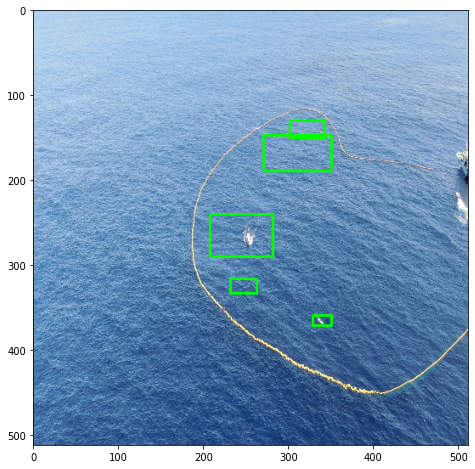

In [118]:
def visualize(idx, model_out):
    images, target, image_id = sub_dataset[idx]
    #images, target, image_id = train_dataset[idx]
    print(image_id)

    
    #boxes = target['boxes'].cpu().numpy().astype(np.int32)
    bbox = model_out[idx].cpu()[0, :, :4]
    score = model_out[idx].cpu()[0, :, 4]
    c = model_out[idx].cpu()[0, :, 5]
    nms_index = nms(bbox, score)
    score,bbox, c = score[nms_index], bbox[nms_index], c[nms_index]
    print(len(score),score)
    th = 0.05
    #score,bbox, c = score[nms_index.unsqueeze(1)], bbox[nms_index].detach().numpy().astype(np.int32), c[nms_index]
    index = score > th
    score, bbox, c = score[index], bbox[index], c[index]
    print(len(score))

    
    numpy_image = images.permute(1,2,0).cpu().numpy()
    numpy_image_resized = cv2.resize(numpy_image, (512, 512))

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in bbox[:5]:
        print(box)
        box = box.detach().numpy()
        #cv2.rectangle(numpy_image_resized, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
        cv2.rectangle(numpy_image_resized, (box[0], box[1]), (box[2],  box[3]), (0, 1, 0), 2)

    #ax.set_axis_off()
    ax.imshow(numpy_image_resized)
    
        
visualize(1, o)

In [ ]:
h = 2160
w = 3840

In [108]:
path = "/home/ubuntu/datasets/signate/fish/train_images/train_0000.jpg"
cv2.imread(path).shape

(2160, 3840, 3)

In [ ]:
0.07080553472042084mary_loss: 0.00000, time: 0.21489
0.8136565685272217mmary_loss: 1.69380, time: 0.28497
0.4372499883174896mmary_loss: 1.44556, time: 0.35866
0.179607555270195ummary_loss: 1.30067, time: 0.44279
0.16996221244335175mary_loss: 1.26152, time: 0.50552
0.22409749031066895mary_loss: 1.45072, time: 0.59160
0.42457953095436096mary_loss: 1.33065, time: 0.69826
0.09361676871776581mary_loss: 1.24154, time: 0.79451
0.4227568209171295mmary_loss: 1.34691, time: 0.89703
0.21441897749900818mary_loss: 1.26096, time: 0.99237
0.15364901721477509mmary_loss: 1.25965, time: 1.07555
0.32070037722587585mmary_loss: 1.30467, time: 1.14825
0.34925219416618347mmary_loss: 1.27886, time: 1.20806
0.39564254879951477mmary_loss: 1.22289, time: 1.29656
0.2572379410266876ummary_loss: 1.23144, time: 1.38504
0.29873010516166687mmary_loss: 1.28111, time: 1.48508
0.8301653861999512ummary_loss: 1.34258, time: 1.57764
0.39498353004455566mmary_loss: 1.29758, time: 1.66865
0.6692066788673401ummary_loss: 1.25275, time: 1.72557
0.2804736793041229ummary_loss: 1.23062, time: 1.80155
0.048449013382196426mary_loss: 1.24252, time: 1.90020
0.5831294655799866ummary_loss: 1.27739, time: 1.99693
0.5584681034088135ummary_loss: 1.26830, time: 2.09288
0.5219141244888306ummary_loss: 1.29918, time: 2.18722
0.32238152623176575mmary_loss: 1.27383, time: 2.28822
0.5004621148109436ummary_loss: 1.28902, time: 2.37343
0.4968484342098236ummary_loss: 1.28985, time: 2.44804
0.07475005090236664mmary_loss: 1.27295, time: 2.50877
0.32658326625823975mmary_loss: 1.28731, time: 2.59975
0.34698379039764404mmary_loss: 1.28145, time: 2.69556
0.6671462059020996ummary_loss: 1.29475, time: 2.79611
0.34105604887008667mmary_loss: 1.28625, time: 2.88045
0.9108724594116211ummary_loss: 1.29837, time: 2.96904
0.6254449486732483ummary_loss: 1.27073, time: 3.05124
0.5353406667709351ummary_loss: 1.27993, time: 3.11312
0.2263701856136322ummary_loss: 1.26199, time: 3.20057
0.4596487581729889ummary_loss: 1.25901, time: 3.29505
0.4780947268009186ummary_loss: 1.25442, time: 3.39530
0.2637086808681488ummary_loss: 1.24456, time: 3.49666
0.20866502821445465mmary_loss: 1.23691, time: 3.59296
0.23255781829357147mmary_loss: 1.22472, time: 3.68179
0.07879124581813812mmary_loss: 1.23724, time: 3.76037
0.7761207222938538ummary_loss: 1.23879, time: 3.81854
0.14278927445411682mmary_loss: 1.21769, time: 3.90175
0.17071357369422913mmary_loss: 1.22573, time: 3.99131
0.08274251967668533mmary_loss: 1.22348, time: 4.09757
0.31575581431388855mmary_loss: 1.24888, time: 4.19294
0.14234240353107452mmary_loss: 1.26015, time: 4.27635
0.09830500930547714mmary_loss: 1.25321, time: 4.34822
0.07622561603784561mmary_loss: 1.27223, time: 4.40908
0.617214024066925summary_loss: 1.27191, time: 4.49926
0.7508096098899841ummary_loss: 1.26549, time: 4.59725
0.10798531025648117mmary_loss: 1.26706, time: 4.69512
0.21680565178394318mmary_loss: 1.27410, time: 4.79412
0.6273868083953857ummary_loss: 1.27452, time: 4.88852
0.8507121801376343ummary_loss: 1.26759, time: 4.96824
0.11497297137975693mmary_loss: 1.24937, time: 5.02305
0.12181462347507477mmary_loss: 1.25073, time: 5.10313
0.32985347509384155mmary_loss: 1.24406, time: 5.18884
0.5465622544288635ummary_loss: 1.23461, time: 5.29641
0.06228965148329735mmary_loss: 1.22646, time: 5.42165
0.0843503400683403ummary_loss: 1.25254, time: 5.49645
0.6891815662384033ummary_loss: 1.26437, time: 5.59954
0.41839587688446045mmary_loss: 1.25131, time: 5.68867
0.4966586232185364ummary_loss: 1.26201, time: 5.77107
0.243289515376091summary_loss: 1.26658, time: 5.84487
0.10694841295480728mmary_loss: 1.26879, time: 5.91107
0.20679056644439697mmary_loss: 1.27982, time: 6.00096
0.432668000459671summary_loss: 1.28743, time: 6.08626
0.28752005100250244mmary_loss: 1.27760, time: 6.18647
0.6359044909477234ummary_loss: 1.27823, time: 6.27994
0.36850306391716003mmary_loss: 1.27047, time: 6.35117
0.8627057075500488ummary_loss: 1.26501, time: 6.41768
0.0676252543926239ummary_loss: 1.25881, time: 6.50236
0.19609412550926208mmary_loss: 1.25927, time: 6.59023
0.253344863653183summary_loss: 1.26683, time: 6.69499
0.11147848516702652mmary_loss: 1.26478, time: 6.78878
0.1805574893951416ummary_loss: 1.26573, time: 6.88694
0.7189616560935974ummary_loss: 1.26059, time: 6.98151
0.2182117998600006ummary_loss: 1.25426, time: 7.06078
0.13604611158370972mmary_loss: 1.25681, time: 7.12107
0.073530413210392summary_loss: 1.24951, time: 7.20027
0.09803864359855652mmary_loss: 1.25916, time: 7.30106
0.8584039211273193ummary_loss: 1.27754, time: 7.39249
0.4850287437438965ummary_loss: 1.26883, time: 7.48666
0.6223948001861572ummary_loss: 1.27275, time: 7.59798
0.33415621519088745mmary_loss: 1.26638, time: 7.69219
0.2224496454000473ummary_loss: 1.26830, time: 7.79069
0.6022577285766602ummary_loss: 1.26068, time: 7.89069
0.4493153393268585ummary_loss: 1.25970, time: 7.96715
0.19548030197620392mmary_loss: 1.25229, time: 8.02222
0.1911786049604416ummary_loss: 1.26090, time: 8.10339
0.06453239917755127mmary_loss: 1.25903, time: 8.19840
0.5234902501106262ummary_loss: 1.26309, time: 8.30128
0.1578146517276764ummary_loss: 1.26236, time: 8.39833
0.14796528220176697mmary_loss: 1.25443, time: 8.49489
0.722081184387207summary_loss: 1.24654, time: 8.59613
0.15857209265232086mmary_loss: 1.24779, time: 8.68610
0.4643262028694153ummary_loss: 1.24984, time: 8.78960
0.43280118703842163mmary_loss: 1.24790, time: 8.86966
0.3029917776584625summary_loss: 1.24668, time: 8.95050
0.4170106053352356summary_loss: 1.24996, time: 9.01021
0.7888478636741638summary_loss: 1.25263, time: 9.09084
0.667292594909668 summary_loss: 1.24461, time: 9.20138
0.12563556432724, summary_loss: 1.24034, time: 9.29495
0.03323663771152496ummary_loss: 1.24614, time: 9.38764
0.5572926998138428summary_loss: 1.25045, time: 9.46972
0.08948291838169098ummary_loss: 1.25683, time: 9.52831
0.24744415283203125ummary_loss: 1.26310, time: 9.59144
0.3338250517845154summary_loss: 1.26523, time: 9.70091
0.2732624113559723summary_loss: 1.26125, time: 9.80257
0.05954781919717789ummary_loss: 1.26393, time: 9.89806
0.1144450232386589summary_loss: 1.27134, time: 9.99625
0.20589987933635712ummary_loss: 1.26504, time: 10.09144
0.1862340271472931summary_loss: 1.26654, time: 10.17969
0.2590707540512085summary_loss: 1.27192, time: 10.25462
0.10134412348270416ummary_loss: 1.27743, time: 10.31538
0.7131801247596741summary_loss: 1.27672, time: 10.40457
0.30631715059280396ummary_loss: 1.26909, time: 10.50168
0.2942197322845459summary_loss: 1.26213, time: 10.59549
0.1806599497795105summary_loss: 1.25685, time: 10.69617
0.2722567617893219summary_loss: 1.26455, time: 10.78800
0.16657264530658722ummary_loss: 1.27144, time: 10.87011
0.22353634238243103ummary_loss: 1.26753, time: 10.94835
0.22133885324001312ummary_loss: 1.27176, time: 11.00974
0.5815981030464172summary_loss: 1.27520, time: 11.10208
0.37320780754089355ummary_loss: 1.27143, time: 11.19411
0.15894733369350433ummary_loss: 1.27039, time: 11.29573
0.47554144263267517ummary_loss: 1.27278, time: 11.39363
0.21330903470516205ummary_loss: 1.28232, time: 11.48301
0.10050705075263977ummary_loss: 1.28429, time: 11.57082
0.6746034026145935summary_loss: 1.28805, time: 11.65219
0.21127066016197205ummary_loss: 1.28409, time: 11.70929
0.5751814842224121summary_loss: 1.28520, time: 11.84420
0.6201505661010742summary_loss: 1.27891, time: 11.90211
0.2990143299102783summary_loss: 1.27602, time: 12.00660
0.8556854724884033summary_loss: 1.27984, time: 12.08735
0.23621606826782227ummary_loss: 1.28143, time: 12.19829
0.17997317016124725ummary_loss: 1.28261, time: 12.29621
0.0635603666305542summary_loss: 1.28486, time: 12.38143
0.1315319985151291summary_loss: 1.28780, time: 12.47862
0.832237958908081 summary_loss: 1.28744, time: 12.55780
0.03122001700103283ummary_loss: 1.28697, time: 12.61471
0.7820597290992737summary_loss: 1.29334, time: 12.70364
0.24453383684158325ummary_loss: 1.28870, time: 12.80716
0.8638224005699158summary_loss: 1.29313, time: 12.90424
0.192058727145195 summary_loss: 1.29152, time: 12.99235
0.16598448157310486ummary_loss: 1.28849, time: 13.09856
0.12645958364009857ummary_loss: 1.29191, time: 13.19702
0.377806156873703 summary_loss: 1.29938, time: 13.29406
0.7366769313812256summary_loss: 1.29341, time: 13.39475
0.4245188236236572summary_loss: 1.28968, time: 13.48702
0.5963048338890076summary_loss: 1.29297, time: 13.56142
0.08826244622468948ummary_loss: 1.29122, time: 13.62204
0.23250538110733032ummary_loss: 1.29969, time: 13.70481
0.03981734812259674ummary_loss: 1.30352, time: 13.79343
0.412757933139801 summary_loss: 1.31886, time: 13.89399
0.49744346737861633ummary_loss: 1.32265, time: 13.99519
0.7704435586929321summary_loss: 1.31750, time: 14.08824
0.053657617419958115mmary_loss: 1.31823, time: 14.19288
0.5049945712089539summary_loss: 1.31955, time: 14.28770
0.6449880599975586summary_loss: 1.31784, time: 14.37710
0.7977852821350098summary_loss: 1.31313, time: 14.47164
0.7698910236358643summary_loss: 1.31117, time: 14.55166
0.3003444969654083summary_loss: 1.30450, time: 14.61494
0.1083265095949173summary_loss: 1.30572, time: 14.70097
0.12304560840129852ummary_loss: 1.30913, time: 14.81523
0.21813622117042542ummary_loss: 1.31307, time: 14.89616
0.0660172626376152summary_loss: 1.31513, time: 15.00068
0.12826581299304962ummary_loss: 1.31747, time: 15.09604
0.8686923980712891summary_loss: 1.32291, time: 15.19099
0.31928741931915283ummary_loss: 1.32489, time: 15.30968
0.07821241021156311ummary_loss: 1.32765, time: 15.39592
0.7557758092880249summary_loss: 1.33093, time: 15.49375
0.06256698817014694ummary_loss: 1.32910, time: 15.58007
0.12324774265289307ummary_loss: 1.33099, time: 15.66043
0.6422903537750244summary_loss: 1.32852, time: 15.72053
0.6491745710372925summary_loss: 1.32766, time: 15.79744
0.6234182119369507summary_loss: 1.32203, time: 15.94464
0.3263718783855438summary_loss: 1.32058, time: 16.00457
0.75826495885849, summary_loss: 1.31812, time: 16.10595
0.10406554490327835ummary_loss: 1.31594, time: 16.19361
0.12217897176742554ummary_loss: 1.32504, time: 16.29681
0.7348700165748596summary_loss: 1.32688, time: 16.38146
0.066770538687706 summary_loss: 1.32470, time: 16.48493
0.5108762979507446summary_loss: 1.32927, time: 16.56995
0.8403477668762207summary_loss: 1.32841, time: 16.65563
0.12240147590637207ummary_loss: 1.32574, time: 16.71332
0.3923964202404022summary_loss: 1.32873, time: 16.80945
0.15775570273399353ummary_loss: 1.32856, time: 16.89310
0.20919948816299438ummary_loss: 1.32475, time: 17.01845
0.654643177986145 summary_loss: 1.32543, time: 17.09617
0.20703467726707458ummary_loss: 1.32214, time: 17.19783
0.08347232639789581ummary_loss: 1.32361, time: 17.29481
0.08111788332462311ummary_loss: 1.32240, time: 17.38816
0.2963237762451172summary_loss: 1.32273, time: 17.46263
0.46428388357162476ummary_loss: 1.32574, time: 17.51924
0.4693377614021301summary_loss: 1.32367, time: 17.60043
0.7902993559837341summary_loss: 1.32486, time: 17.70419
0.4744716286659241summary_loss: 1.32070, time: 17.79928
0.11306118220090866ummary_loss: 1.31696, time: 17.89885
0.37317466735839844ummary_loss: 1.31662, time: 17.98812
0.548376739025116 summary_loss: 1.31640, time: 18.07794
0.10593654215335846ummary_loss: 1.31367, time: 18.14526
0.7802967429161072summary_loss: 1.32059, time: 18.20842
0.5090145468711853summary_loss: 1.31611, time: 18.30062
0.3841512203216553summary_loss: 1.31594, time: 18.39828
0.30112776160240173ummary_loss: 1.31719, time: 18.49218
0.2949296236038208summary_loss: 1.31885, time: 18.59506
0.30634814500808716ummary_loss: 1.32090, time: 18.69389
0.32247400283813477ummary_loss: 1.32292, time: 18.78445
0.41412553191185, summary_loss: 1.32496, time: 18.87963
0.29910439252853394ummary_loss: 1.32292, time: 18.96189
0.09046881645917892ummary_loss: 1.32197, time: 19.01605
0.05732280761003494ummary_loss: 1.32509, time: 19.09841
0.09672055393457413ummary_loss: 1.32691, time: 19.19396
0.41464704275131226ummary_loss: 1.32785, time: 19.28692
0.8458741307258606summary_loss: 1.32529, time: 19.37502
0.4569045305252075summary_loss: 1.32058, time: 19.47593
0.5004257559776306summary_loss: 1.31857, time: 19.54939
0.0891367644071579summary_loss: 1.31485, time: 19.61330
0.39551353454589844ummary_loss: 1.31607, time: 19.70023
0.8545085787773132summary_loss: 1.31455, time: 19.80007
0.767990231513977 summary_loss: 1.31041, time: 19.89762
0.18175441026687622ummary_loss: 1.30678, time: 19.99720
0.6175985932350159summary_loss: 1.30430, time: 20.08698
0.45749300718307495ummary_loss: 1.30079, time: 20.17906
0.3319692611694336summary_loss: 1.29901, time: 20.27971
0.1491835117340088summary_loss: 1.29682, time: 20.36305
0.3514326810836792summary_loss: 1.29656, time: 20.44421
0.1291453093290329summary_loss: 1.29831, time: 20.53252
0.28276342153549194ummary_loss: 1.29925, time: 20.59785
0.7473376393318176summary_loss: 1.30120, time: 20.70071
0.2846201956272125summary_loss: 1.30207, time: 20.79819
0.40924376249313354ummary_loss: 1.30297, time: 20.90198
0.6691031455993652summary_loss: 1.30325, time: 20.99560
0.16651850938796997ummary_loss: 1.30168, time: 21.08958
0.1020696684718132summary_loss: 1.30237, time: 21.18837